In [51]:
from pathlib import Path
import mbo_utilities as mbo
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from skimage.registration import phase_cross_correlation

In [52]:
inpath = Path().home() / "Documents/data/yao"
data = mbo.imread(inpath)
frame = data[14, 0, :, :]

print(f'Frame shape: {frame.shape}')
print(f'Frame range: [{frame.min()}, {frame.max()}]')

Counting frames:   0%|          | 0/3 [00:00<?, ?it/s]

Frame shape: (512, 512)
Frame range: [-8, 4493]


## Analyze Spatial Variation

In [53]:
def analyze_phase_variation(frame, window_size=64, stride=32, upsample=10, min_intensity=50):
    pre = frame[::2]
    post = frame[1::2]
    m = min(pre.shape[0], post.shape[0])
    a, b = pre[:m], post[:m]
    h, w = a.shape
    
    x_positions, shifts = [], []
    
    for y in range(0, h - window_size, stride):
        for x in range(0, w - window_size, stride):
            window_a = a[y:y+window_size, x:x+window_size]
            window_b = b[y:y+window_size, x:x+window_size]
            mean_intensity = (window_a.mean() + window_b.mean()) / 2
            
            if mean_intensity < min_intensity:
                continue
            
            try:
                shift_2d, _, _ = phase_cross_correlation(window_a, window_b, upsample_factor=upsample)
                x_positions.append(x + window_size // 2)
                shifts.append(float(shift_2d[1]))
            except:
                continue
    
    return np.array(x_positions), np.array(shifts)

x_pos, shifts = analyze_phase_variation(frame)
print(f'Analyzed {len(shifts)} windows')
print(f'Shift range: [{shifts.min():.3f}, {shifts.max():.3f}] px')
print(f'Total variation: {shifts.max() - shifts.min():.3f} px')

Analyzed 70 windows
Shift range: [-1.700, 6.400] px
Total variation: 8.100 px


## Fit Multiple Models

In [54]:
# Define fitting functions
def linear_model(x, a, b):
    return a * x + b

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

def sine_model(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

def cosine_model(x, amplitude, frequency, phase, offset):
    return amplitude * np.cos(2 * np.pi * frequency * x + phase) + offset

# Normalize x to [0, 1] for fitting
x_norm = x_pos / frame.shape[1]

# Fit linear
linear_params, _ = curve_fit(linear_model, x_norm, shifts)
print(f'Linear fit: {linear_params[0]:.3f}*x + {linear_params[1]:.3f}')

# Fit quadratic
quad_params, _ = curve_fit(quadratic_model, x_norm, shifts)
print(f'Quadratic fit: {quad_params[0]:.3f}*x^2 + {quad_params[1]:.3f}*x + {quad_params[2]:.3f}')

# Fit sine (initial guess based on data)
amp_guess = (shifts.max() - shifts.min()) / 2
offset_guess = shifts.mean()
freq_guess = 0.5  # Try half cycle across image
try:
    sine_params, _ = curve_fit(sine_model, x_norm, shifts, 
                               p0=[amp_guess, freq_guess, 0, offset_guess],
                               maxfev=10000)
    print(f'Sine fit: {sine_params[0]:.3f}*sin(2π*{sine_params[1]:.3f}*x + {sine_params[2]:.3f}) + {sine_params[3]:.3f}')
except:
    print('Sine fit failed')
    sine_params = None

# Fit cosine
try:
    cos_params, _ = curve_fit(cosine_model, x_norm, shifts,
                              p0=[amp_guess, freq_guess, 0, offset_guess],
                              maxfev=10000)
    print(f'Cosine fit: {cos_params[0]:.3f}*cos(2π*{cos_params[1]:.3f}*x + {cos_params[2]:.3f}) + {cos_params[3]:.3f}')
except:
    print('Cosine fit failed')
    cos_params = None

Linear fit: -0.031*x + 1.736
Quadratic fit: 42.884*x^2 + -40.704*x + 8.991
Sine fit: -5.394*sin(2π*0.734*x + -0.613) + 4.497
Cosine fit: 5.394*cos(2π*0.734*x + 0.958) + 4.497


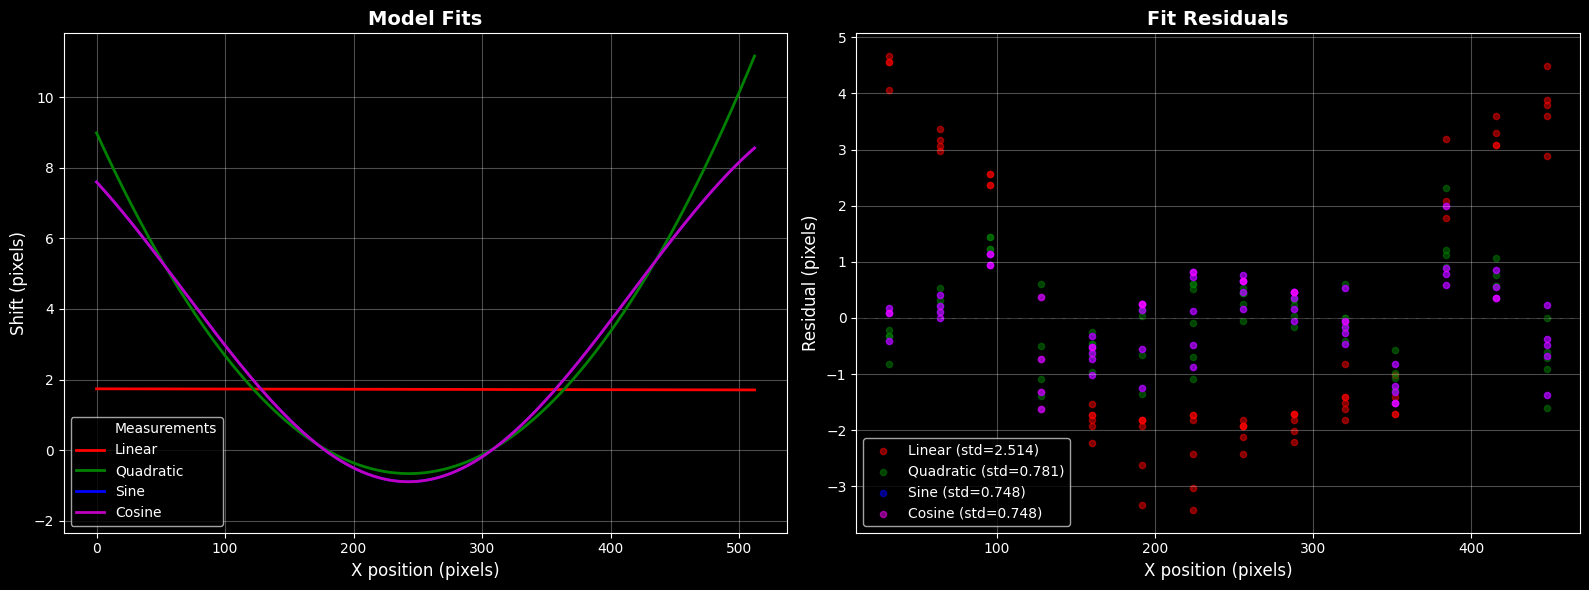


Best fit: Sine (residual std = 0.748 px)


In [55]:
# Plot all fits
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_dense = np.linspace(0, 1, 1000)
x_pixels = x_dense * frame.shape[1]

# Left: All models
axes[0].scatter(x_pos, shifts, c='black', s=30, alpha=0.5, label='Measurements')
axes[0].plot(x_pixels, linear_model(x_dense, *linear_params), 'r-', linewidth=2, label='Linear')
axes[0].plot(x_pixels, quadratic_model(x_dense, *quad_params), 'g-', linewidth=2, label='Quadratic')
if sine_params is not None:
    axes[0].plot(x_pixels, sine_model(x_dense, *sine_params), 'b-', linewidth=2, label='Sine')
if cos_params is not None:
    axes[0].plot(x_pixels, cosine_model(x_dense, *cos_params), 'm-', linewidth=2, label='Cosine')
axes[0].set_xlabel('X position (pixels)', fontsize=12)
axes[0].set_ylabel('Shift (pixels)', fontsize=12)
axes[0].set_title('Model Fits', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Residuals
linear_residuals = shifts - linear_model(x_norm, *linear_params)
quad_residuals = shifts - quadratic_model(x_norm, *quad_params)

axes[1].scatter(x_pos, linear_residuals, c='red', s=20, alpha=0.5, label=f'Linear (std={np.std(linear_residuals):.3f})')
axes[1].scatter(x_pos, quad_residuals, c='green', s=20, alpha=0.5, label=f'Quadratic (std={np.std(quad_residuals):.3f})')
if sine_params is not None:
    sine_residuals = shifts - sine_model(x_norm, *sine_params)
    axes[1].scatter(x_pos, sine_residuals, c='blue', s=20, alpha=0.5, label=f'Sine (std={np.std(sine_residuals):.3f})')
if cos_params is not None:
    cos_residuals = shifts - cosine_model(x_norm, *cos_params)
    axes[1].scatter(x_pos, cos_residuals, c='magenta', s=20, alpha=0.5, label=f'Cosine (std={np.std(cos_residuals):.3f})')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('X position (pixels)', fontsize=12)
axes[1].set_ylabel('Residual (pixels)', fontsize=12)
axes[1].set_title('Fit Residuals', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report best fit
residual_stds = {'Linear': np.std(linear_residuals), 'Quadratic': np.std(quad_residuals)}
if sine_params is not None:
    residual_stds['Sine'] = np.std(sine_residuals)
if cos_params is not None:
    residual_stds['Cosine'] = np.std(cos_residuals)

best_model = min(residual_stds, key=residual_stds.get)
print(f'\nBest fit: {best_model} (residual std = {residual_stds[best_model]:.3f} px)')

## Apply Best Model Correction

In [63]:
# Choose model (change this based on what fits best)
use_model = 'sine'  # 'linear', 'quadratic', 'sine', or 'cosine'

# Compute shift for each column
x_columns = np.arange(frame.shape[1])
x_columns_norm = x_columns / frame.shape[1]

if use_model == 'linear':
    shift_per_column = linear_model(x_columns_norm, *linear_params)
elif use_model == 'quadratic':
    shift_per_column = quadratic_model(x_columns_norm, *quad_params)
elif use_model == 'sine':
    shift_per_column = sine_model(x_columns_norm, *sine_params)
elif use_model == 'cosine':
    shift_per_column = cosine_model(x_columns_norm, *cos_params)

print(f'Using {use_model} model')
print(f'Shift range: [{shift_per_column.min():.3f}, {shift_per_column.max():.3f}] px')

# Apply correction
def apply_column_phase_correction(frame, shift_per_column):
    corrected = frame.copy()
    for col in range(frame.shape[1]):
        shift = shift_per_column[col]
        odd_rows = corrected[1::2, col]
        
        if abs(shift) > 0.01:
            freq = np.fft.fftfreq(len(odd_rows))
            phase_shift = np.exp(-2j * np.pi * freq * shift)
            corrected[1::2, col] = np.fft.ifft(np.fft.fft(odd_rows) * phase_shift).real
    
    return corrected

corrected = apply_column_phase_correction(frame, shift_per_column)
print('Done!')

Using sine model
Shift range: [-0.898, 8.533] px
Done!


## Visualize Correction

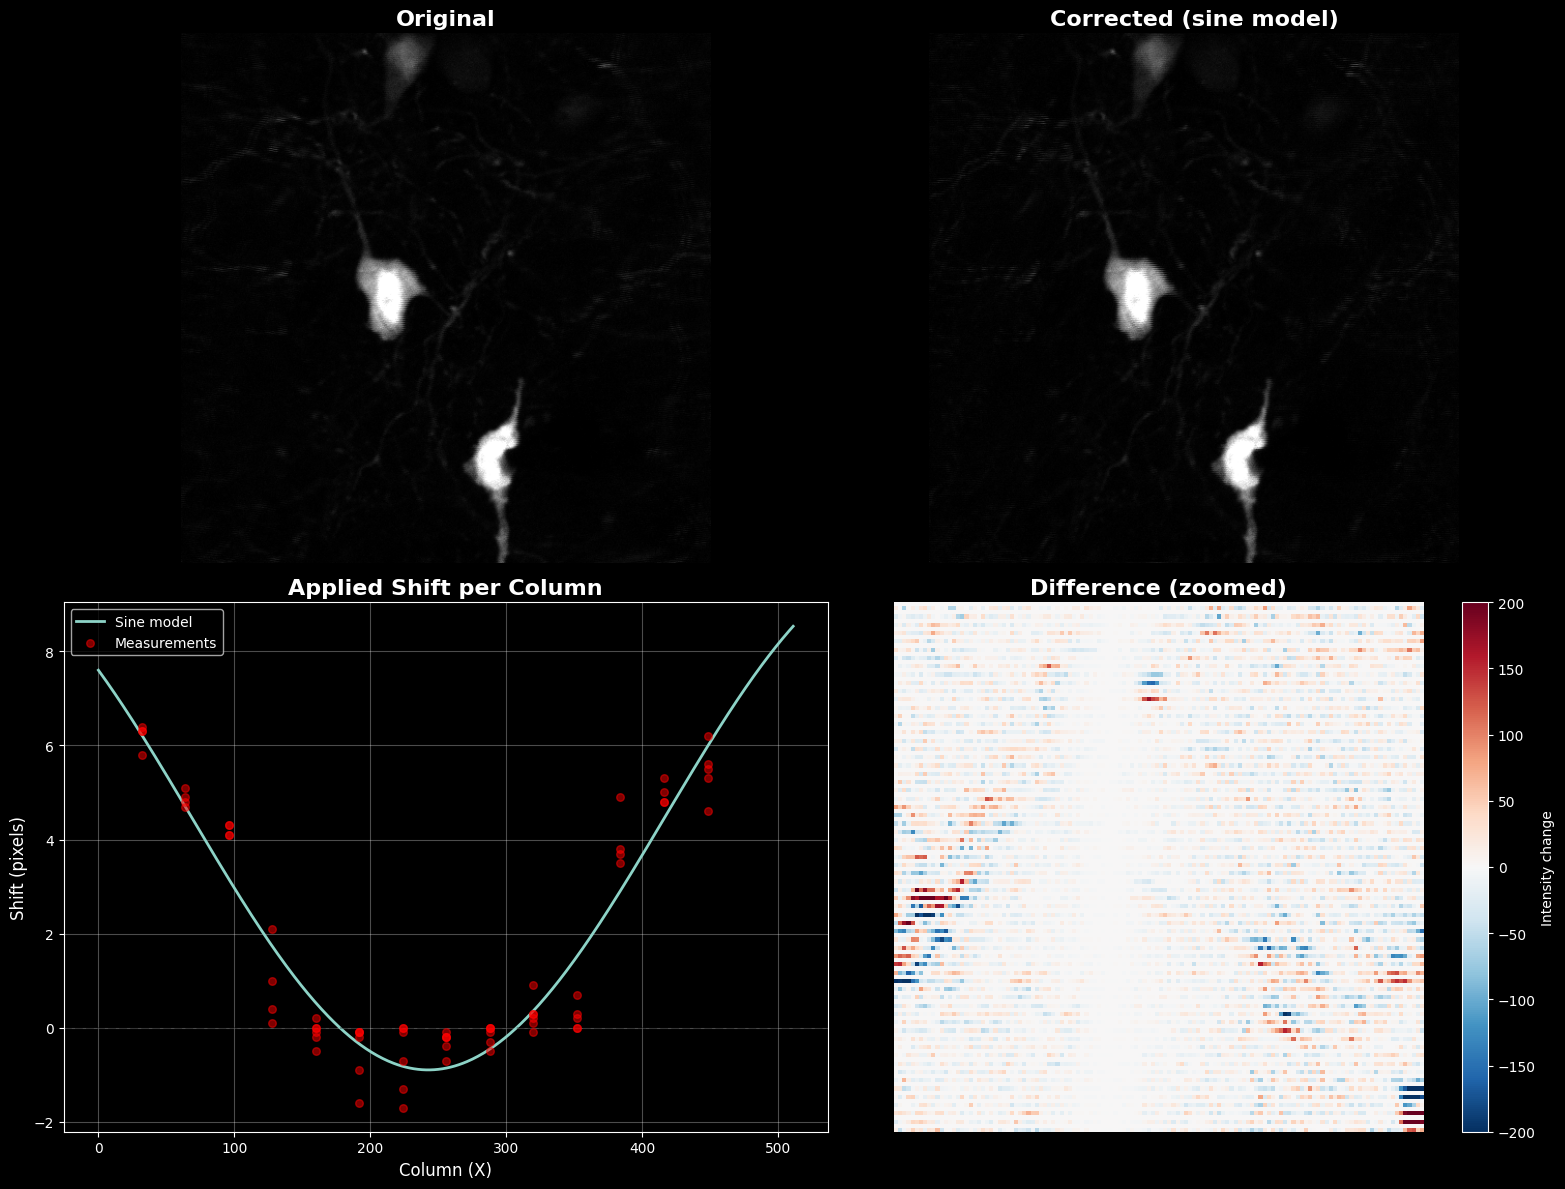

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
vmin, vmax = np.percentile(frame, [1, 99.5])

# Original
axes[0, 0].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Original', fontsize=16, weight='bold')
axes[0, 0].axis('off')

# Corrected
axes[0, 1].imshow(corrected, cmap='gray', vmin=vmin, vmax=vmax)
axes[0, 1].set_title(f'Corrected ({use_model} model)', fontsize=16, weight='bold')
axes[0, 1].axis('off')

# Shift map
axes[1, 0].plot(shift_per_column, linewidth=2, label=f'{use_model.capitalize()} model')
axes[1, 0].scatter(x_pos, shifts, c='red', s=30, zorder=10, alpha=0.5, label='Measurements')
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Column (X)', fontsize=12)
axes[1, 0].set_ylabel('Shift (pixels)', fontsize=12)
axes[1, 0].set_title('Applied Shift per Column', fontsize=16, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Difference (zoomed)
y, x, size = 192, 256, 128
diff = corrected[y:y+size, x:x+size] - frame[y:y+size, x:x+size]
im = axes[1, 1].imshow(diff, cmap='RdBu_r', vmin=-200, vmax=200)
axes[1, 1].set_title(f'Difference (zoomed)', fontsize=16, weight='bold')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], label='Intensity change')

plt.tight_layout()
plt.show()

## Compare Left/Center/Right Regions

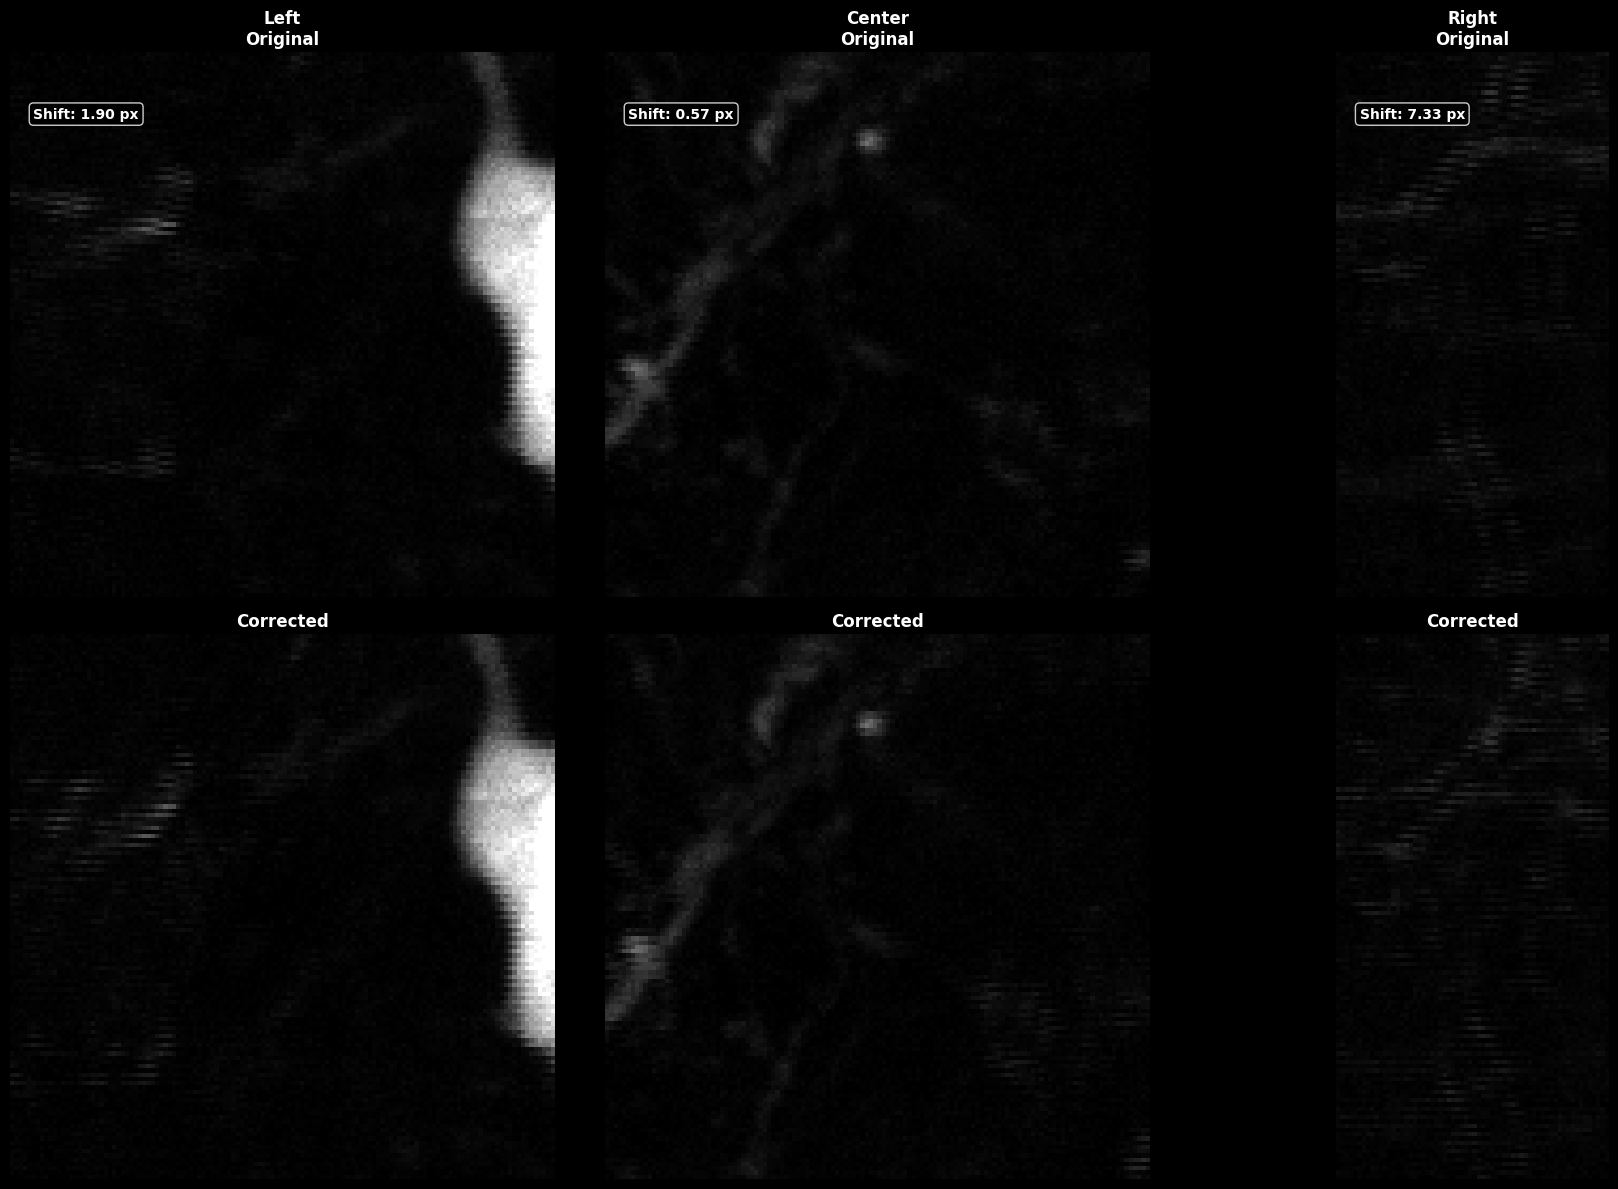

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
regions = [("Left", 192, 64), ("Center", 192, 256), ("Right", 192, 448)]
size = 128
vmin_z, vmax_z = np.percentile(frame, [5, 99])

for i, (label, y, x) in enumerate(regions):
    # Original
    axes[0, i].imshow(frame[y:y+size, x:x+size], cmap='gray', vmin=vmin_z, vmax=vmax_z)
    axes[0, i].set_title(f'{label}\nOriginal', fontsize=12, weight='bold')
    axes[0, i].axis('off')
    
    # Show shift value
    mean_shift = shift_per_column[x:x+size].mean()
    axes[0, i].text(5, 15, f'Shift: {mean_shift:.2f} px',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.8),
                   fontsize=10, weight='bold')
    
    # Corrected
    axes[1, i].imshow(corrected[y:y+size, x:x+size], cmap='gray', vmin=vmin_z, vmax=vmax_z)
    axes[1, i].set_title('Corrected', fontsize=12, weight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

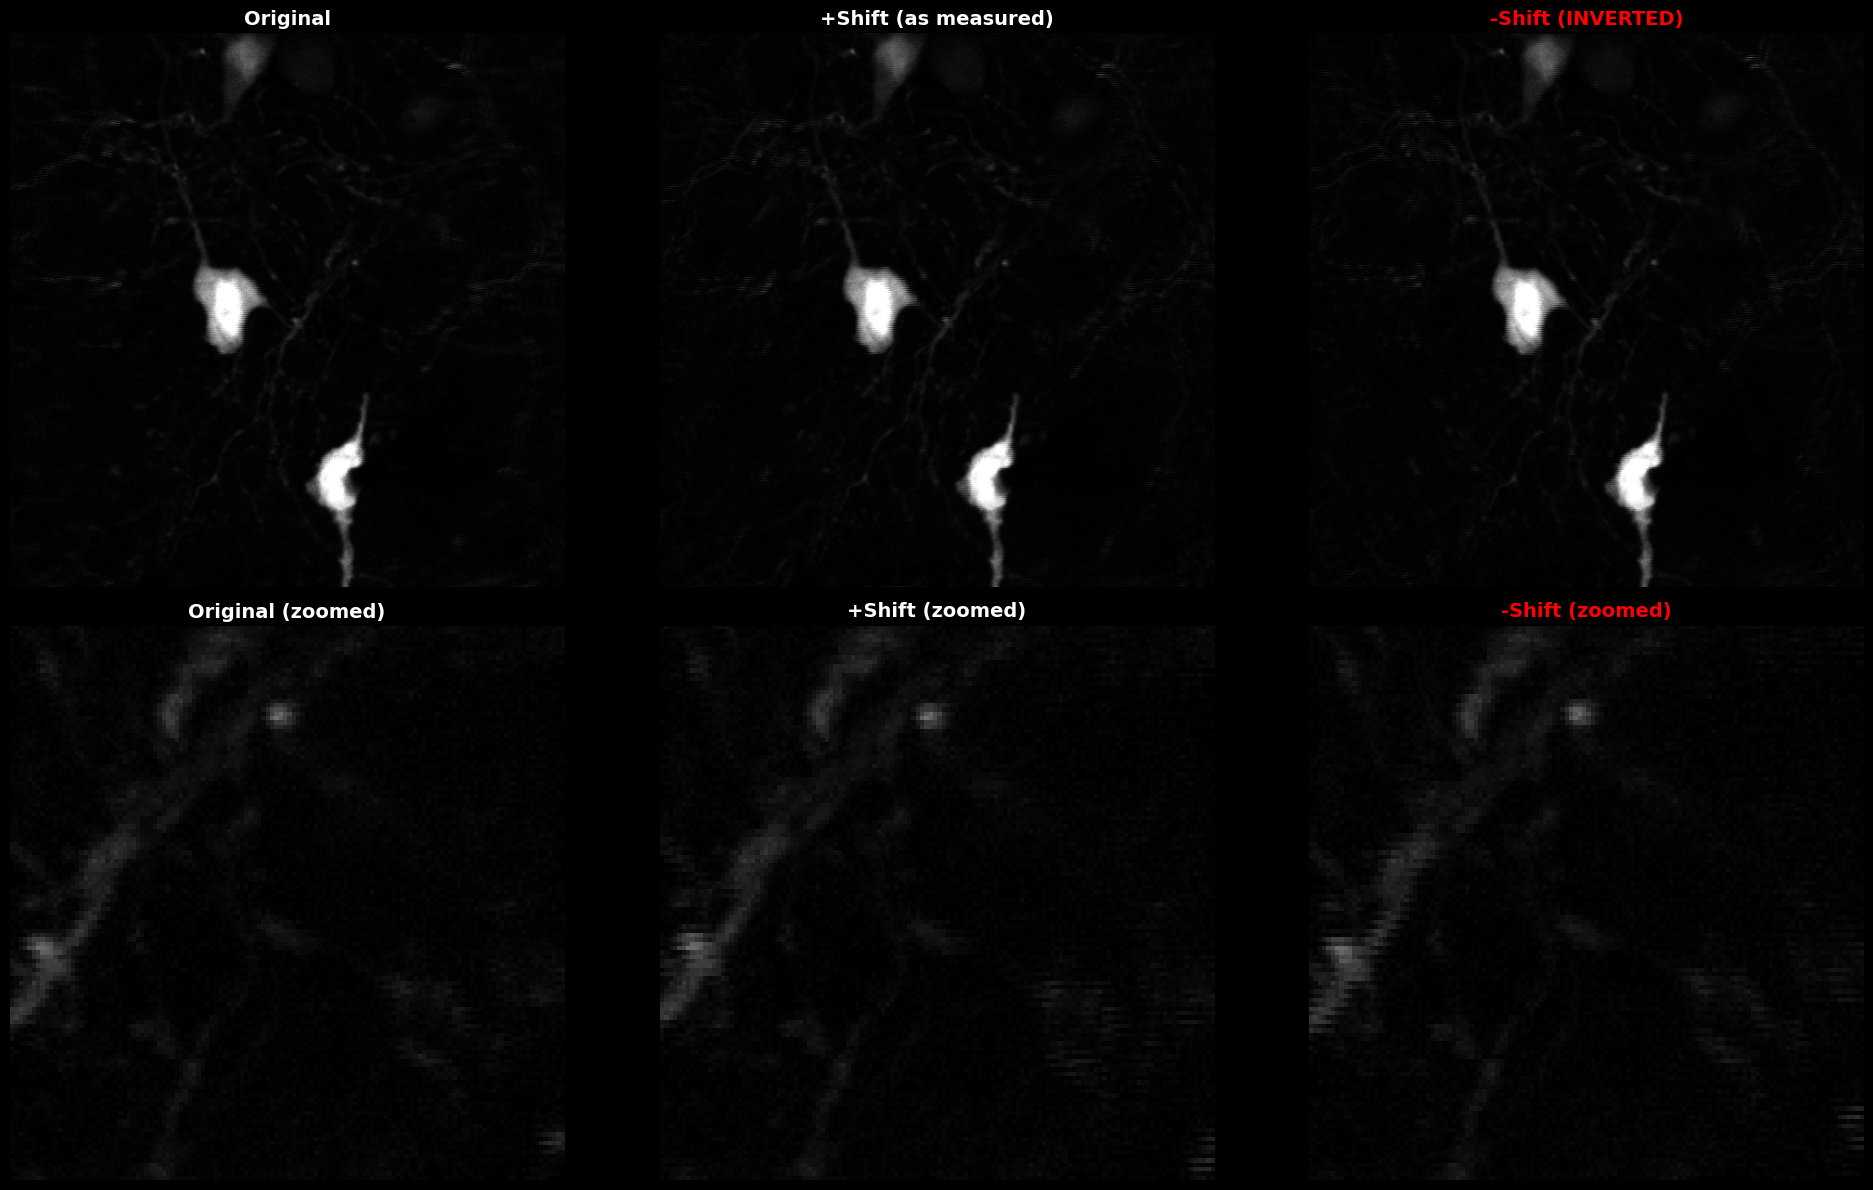

WHICH LOOKS BETTER?
Look at the edges/neurons in the zoomed images.
If -Shift (RIGHT column) looks SHARPER/BETTER aligned,
then change the correction line to:
  corrected = apply_column_phase_correction(frame, -shift_per_column)


In [59]:
# Add this cell to your notebook right after the "Apply Best Model Correction" section

## TEST BOTH SHIFT DIRECTIONS
# Test if we should apply +shift or -shift

corrected_positive = apply_column_phase_correction(frame, shift_per_column)
corrected_negative = apply_column_phase_correction(frame, -shift_per_column)  # INVERTED

# Compare side-by-side
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
vmin, vmax = np.percentile(frame, [1, 99.5])

# Full frames
axes[0, 0].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Original', fontsize=14, weight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(corrected_positive, cmap='gray', vmin=vmin, vmax=vmax)
axes[0, 1].set_title('+Shift (as measured)', fontsize=14, weight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(corrected_negative, cmap='gray', vmin=vmin, vmax=vmax)
axes[0, 2].set_title('-Shift (INVERTED)', fontsize=14, weight='bold', color='red')
axes[0, 2].axis('off')

# Zoomed regions (center)
y, x, size = 192, 256, 128
vmin_z, vmax_z = np.percentile(frame, [5, 99])

axes[1, 0].imshow(frame[y:y+size, x:x+size], cmap='gray', vmin=vmin_z, vmax=vmax_z)
axes[1, 0].set_title('Original (zoomed)', fontsize=14, weight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(corrected_positive[y:y+size, x:x+size], cmap='gray', vmin=vmin_z, vmax=vmax_z)
axes[1, 1].set_title('+Shift (zoomed)', fontsize=14, weight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(corrected_negative[y:y+size, x:x+size], cmap='gray', vmin=vmin_z, vmax=vmax_z)
axes[1, 2].set_title('-Shift (zoomed)', fontsize=14, weight='bold', color='red')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("="*70)
print("WHICH LOOKS BETTER?")
print("="*70)
print("Look at the edges/neurons in the zoomed images.")
print("If -Shift (RIGHT column) looks SHARPER/BETTER aligned,")
print("then change the correction line to:")
print("  corrected = apply_column_phase_correction(frame, -shift_per_column)")
print("="*70)

## Save Results

In [ ]:
import tifffile

output_dir = Path().home() / "Documents/data/yao"
tifffile.imwrite(output_dir / "corrected_frame.tif", corrected.astype(np.int16))
np.save(output_dir / "shift_per_column.npy", shift_per_column)
print(f'Saved to {output_dir}/')
print(f'  - corrected_frame.tif')
print(f'  - shift_per_column.npy')
print(f'  Model used: {use_model}'